In [1]:
import os
# Verificación y ubicación (y descarga de archivos en colab)
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name != 'Datos y código - Práctica 3':
    try:
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 3/")
    except FileNotFoundError:
        !git clone https://github.com/agustinbrusco/Laboratorio_5_Datos.git
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 3/")

In [2]:
import numpy as np
from scipy.stats import poisson
from scipy.optimize import curve_fit
try:
    import utils as ut
except TypeError:
    import utils_colab as ut
import matplotlib.pyplot as plt
import seaborn as sns
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True


config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

## Respuesta a un Fotón

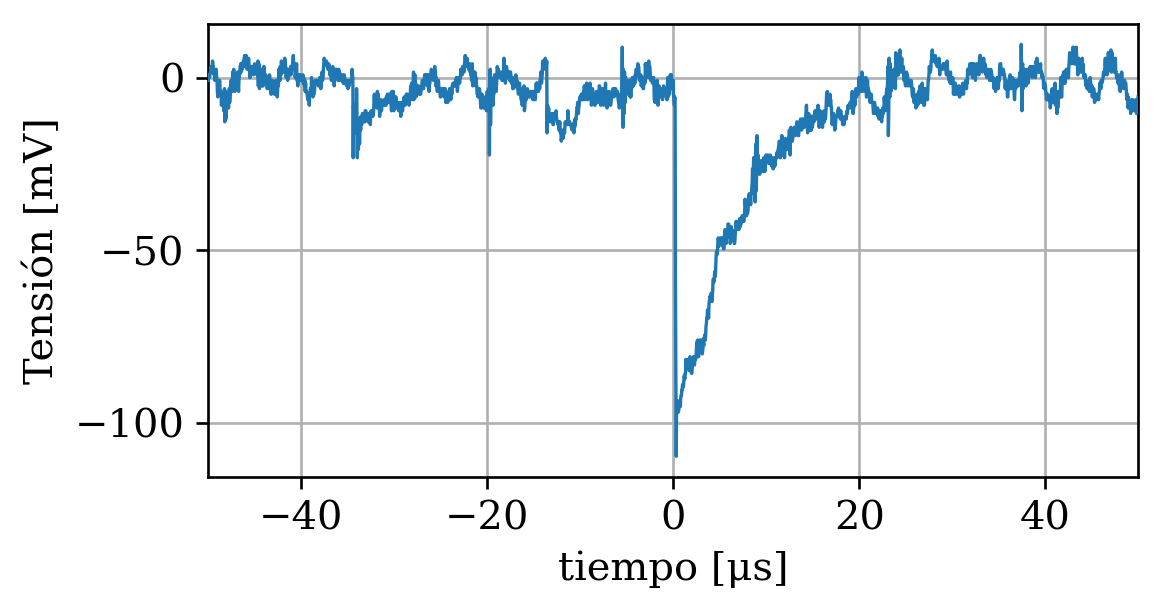

In [3]:
# Datos Guardados en Misc:
tiempo, channel = np.load(f"misc/20mV_10microseg_foton.npy")  # s, V
v_res = 20e-3*10/(2**8)  # V
t_res = 10e-6*10/2500  # s

x = tiempo*1e6  # μs
dx = t_res/2*1e6  # μs
y = channel*1e3  # mV
dy = v_res/2*1e3  # mV

fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.patch.set_alpha(0)
# plt.errorbar(x, y, xerr=dx, yerr=dy,
#              fmt=".-", lw=0.5, ms=4, mec="k", mew=0.5,
#              ecolor="k", capsize=2, alpha=0.5, zorder=10)
plt.plot(x, y, "-", lw=1,
        #  ms=4, mec="k", mew=0.25,
         alpha=1, zorder=10)
plt.xlabel(r"tiempo [μs]")
plt.ylabel(r"Tensión [mV]")
plt.show()

## Extremos en Ventanas

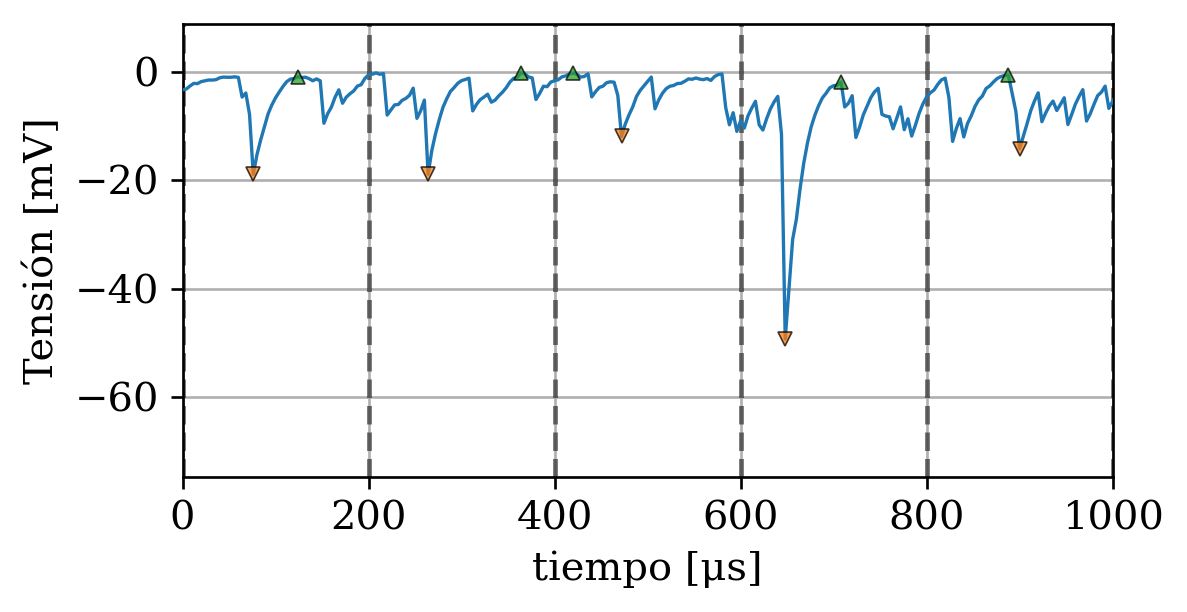

In [4]:
# Leer una tanda guardada:
config = "d"  # Estado del instrumental al medir
tension = 1050  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo, channel = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                           + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
v_res = 1.05*(max_val - min_val)/(2**16)  # V
t_res = 1/freq  # s

t_inicial = 0.44  # s
t_final = 0.441  # s


x = (tiempo - t_inicial)*1e6  # μs
dx = t_res/2*1e6  # μs
y = channel*1e3  # mV
dy = v_res/2*1e3  # mV

dt = 200  # μs
px, py = ut.get_peaks(x, y, int(dt*freq*1e-6))

fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.patch.set_alpha(0)
# plt.errorbar(x, y, xerr=dx, yerr=dy,
#              fmt=".-", lw=0.5, ms=4, mec="k", mew=0.5,
#              ecolor="k", capsize=2, alpha=0.5, zorder=10)
plt.plot(x, y, "-", lw=1,
        #  ms=4, mec="k", mew=0.25,
         alpha=1, zorder=10)
plt.plot(px[:px.size//2], py[:px.size//2],
         "v", ms=4, mec="k", mew=0.5,
         alpha=0.75, zorder=10)
plt.plot(px[px.size//2:], py[px.size//2:],
         "^", ms=4, mec="k", mew=0.5,
         alpha=0.75, zorder=10)
for intervalo in np.arange(0, (t_final - t_inicial)*1e6, dt):  # μs
        plt.axvline(intervalo, ls="--", c='k', alpha=0.5)
plt.xlim(0, (t_final - t_inicial)*1e6)
plt.xlabel(r"tiempo [μs]")
plt.ylabel(r"Tensión [mV]")
plt.show()

## Distribución de Extremos de Tensión

loaded a
ploted hist
loaded b
ploted hist
loaded c
ploted hist
loaded d
ploted hist


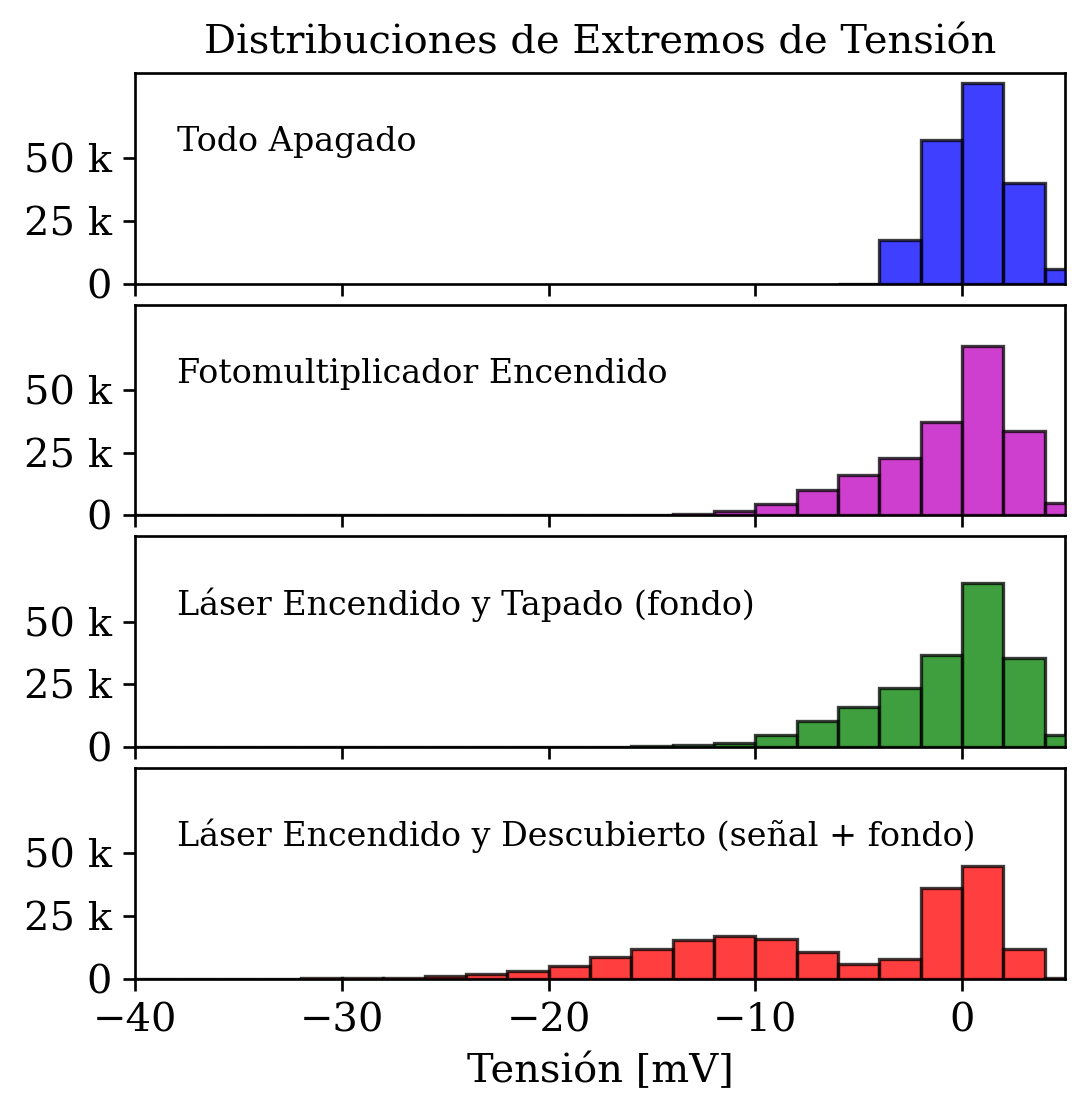

In [10]:
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
angulo = 230  # °
tension = 1050  # V
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V

with plt.rc_context({
    'text.color': "k",
    'axes.labelcolor': "k",
    'xtick.color': "k",
    'ytick.color': "k",
    }):
    fig, axs = plt.subplots(4, 1, figsize=(5, 5),
                            sharex=True, sharey=True
                            )
    fig.subplots_adjust(hspace=0.1)
    color_id = 4
    height_dict = dict()
    tension_dict = dict()
    for config, bar_color, tag, ax in zip(
        ["a", "b", "c", "d"],
        ["b", "m", "g", "r"],
        ["Todo Apagado", "Fotomultiplicador Encendido",
         "Láser Encendido y Tapado (fondo)", "Láser Encendido y Descubierto (señal + fondo)"],
        axs,
        ):
        ax.text(-38, 50e3, tag, ha="left", va="bottom")
        ax.grid(False)
        ax.patch.set_alpha(0)
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
        tiempo, volt_vals = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                                    + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
        print(f"loaded {config}")
        bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # mV
        bins = bin_range[(volt_vals.max()*1e3 + 2 >= bin_range) & (volt_vals.min()*1e3 - 2 <= bin_range)]  # mV
        bin_centers = (bins[1:] + bins[:-1])/2  # mV
        dt = 100  # μs
        t, v = ut.get_peaks(tiempo, volt_vals, int(dt*freq*1e-6))
        obs, *_ = np.histogram(v[:v.size//2]*1e3, bins, )
        normalized_heights = obs/np.sum(obs[bin_centers >= -6])
        ax.hist(x=v*1e3, bins=bins,
                color=bar_color, zorder=10, edgecolor="k",
                alpha=0.75, label=config + " Sample")
        # ax.hist(bin_centers, bins, weights=normalized_heights,
        #         color=bar_color, zorder=10, edgecolor="k",
        #         alpha=0.75, label=config + " Sample")
        # ax.bar(bin_centers, normalized_heights,
        #        width=2, color=bar_color, edgecolor="k",
        #        alpha=0.75, zorder=10,)
        height_dict[config] = normalized_heights
        tension_dict[config] = bin_centers
        print("ploted hist")
        color_id -= 1

        # ax.set_yscale("log")

    ax.set_xlabel("Tensión [mV]")
    ax.set_xlim(-40, 5)
    
    ax.set_yticks([0, 25e3, 50e3])
    ax.set_yticklabels(["0", r"25 k", r"50 k",])
    
    axs[0].set_title("Distribuciones de Extremos de Tensión")
    plt.show()

## Umbral de Detección

loaded c
ploted hist
loaded d
ploted hist


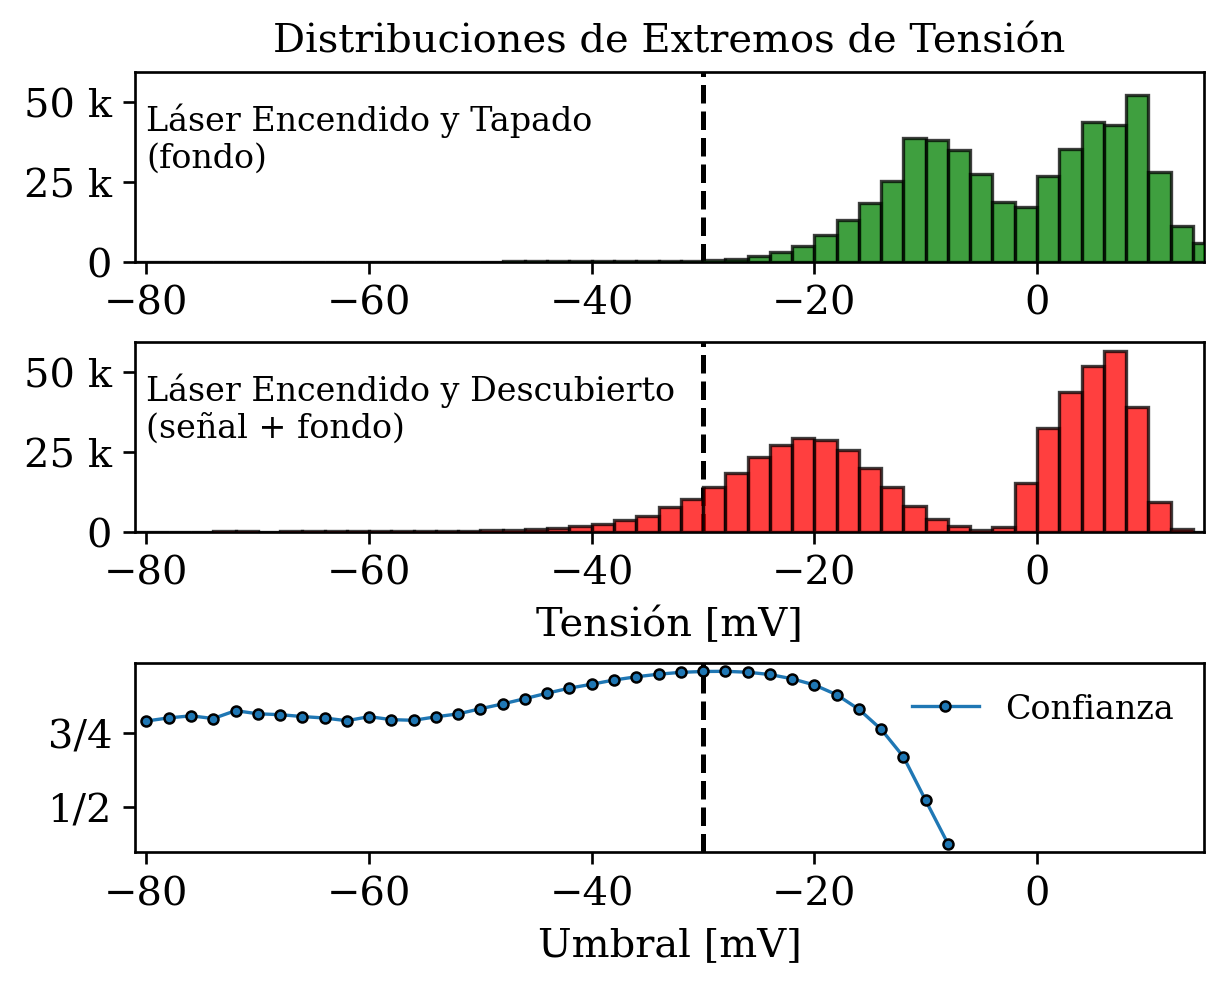

In [11]:
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
angulo = 230  # °
tension = 1050  # V
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V

with plt.rc_context({
    'text.color': "k",
    'axes.labelcolor': "k",
    'xtick.color': "k",
    'ytick.color': "k",
    }):
    fig, axs = plt.subplots(3, 1, figsize=(5, 4),
                            sharex=False, sharey=False,
                            constrained_layout=True
                            )
    # fig.subplots_adjust(hspace=0.1)
    color_id = 4
    height_dict = dict()
    tension_dict = dict()
    for config, bar_color, tag, ax in zip(
        ["c", "d"],
        ["g", "r"],
        ["Láser Encendido y Tapado\n(fondo)", "Láser Encendido y Descubierto\n(señal + fondo)"],
        axs,
        ):
        ax.text(-80, 50e3, tag, ha="left", va="top")
        ax.grid(False)
        ax.patch.set_alpha(0)
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
        tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                                    + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
        print(f"loaded {config}")
        bin_range = np.arange(min_val*1e3, max_val*1e3, 2)  # mV
        bins = bin_range[(volt_vals.max()*1e3 + 2 >= bin_range) & (volt_vals.min()*1e3 - 2 <= bin_range)]  # mV
        bin_centers = (bins[1:] + bins[:-1])/2  # mV
        dt = 200  # μs
        t, v = ut.get_peaks(tiempo, volt_vals, int(dt*freq*1e-6))
        obs, *_ = np.histogram(v[:v.size//2]*1e3, bins, )
        normalized_heights = obs/np.sum(obs[bin_centers >= -6])
        ax.hist(x=v*1e3, bins=bins,
                color=bar_color, zorder=10, edgecolor="k",
                alpha=0.75, label=config + " Sample")
        # ax.hist(bin_centers, bins, weights=normalized_heights,
        #         color=bar_color, zorder=10, edgecolor="k",
        #         alpha=0.75, label=config + " Sample")
        # ax.bar(bin_centers, normalized_heights,
        #        width=2, color=bar_color, edgecolor="k",
        #        alpha=0.75, zorder=10,)
        height_dict[config] = obs#normalized_heights
        tension_dict[config] = bin_centers
        print("ploted hist")
        color_id -= 1

        # ax.set_yscale("log")

    ax.set_xlabel("Tensión [mV]")
    
    axs[1].set_yticks([0, 25e3, 50e3])
    axs[1].set_yticklabels(["0", r"25 k", r"50 k",])
    axs[0].sharey(axs[1])
    axs[0].sharex(axs[1])
    axs[0].set_title("Distribuciones de Extremos de Tensión")

    axs[2].patch.set_alpha(0)
    for spine in axs[2].spines.values():
        spine.set_edgecolor('k')
    config_fondo = "c"
    config_signal = "d"
    umbrales = np.arange(-80, -6, 2, dtype=float)  # mV
    frac = np.zeros_like(umbrales)
    for i, umbral in enumerate(umbrales):  # V
        signal_and_back = sum(height_dict[config_signal][tension_dict[config_signal] <  umbral])
        background = sum(height_dict[config_fondo][tension_dict[config_fondo] <  umbral])
        # print(signal_and_back, background, umbral)
        frac[i] = (signal_and_back-background)/signal_and_back

    plt.plot(umbrales, frac, '.-', lw=1, mec="k", mew=0.75, label=r"Confianza")
    for ax in axs:
        ax.set_xlim(-81, 15)
        ax.axvline(-30, ls='--', c="k", zorder=0.5)
    plt.grid(False)
    plt.xlabel("Umbral [mV]")
    plt.legend(frameon=False, )
    plt.yticks([0.5, 0.75], labels=["1/2", "3/4"])
    plt.show()

## Conteo en Ventanas

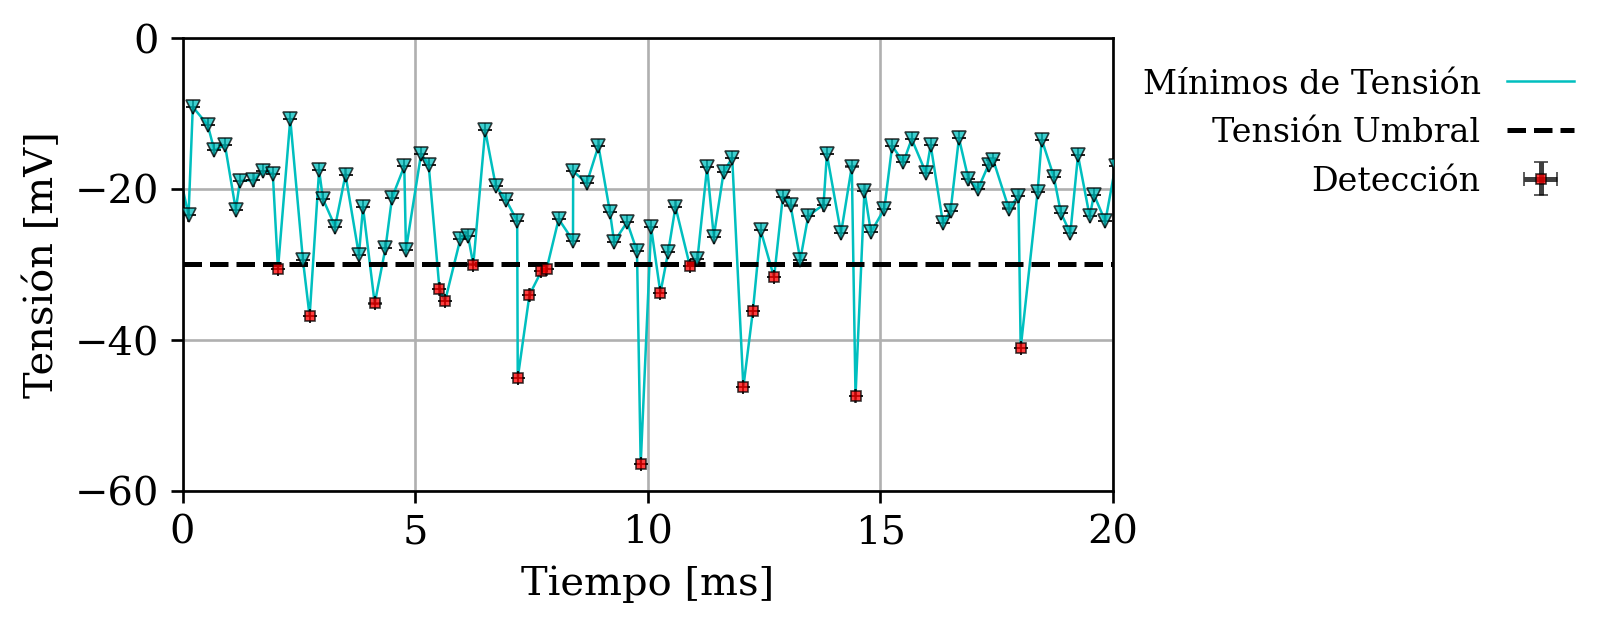

In [12]:
# Leer una tanda guardada:
config = "d"  # Estado del instrumental al medir
tension = 1050  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
freq = 250e3  # Hz
max_val = 50e-3  # V
min_val = -150e-3  # V
modo = "sample"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo, channel = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                           + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
tiempo, channel = tiempo[:250000], channel[:250000]
v_res = 1.05*(max_val - min_val)/(2**16)  # V
t_res = 1/freq  # s

t_inicial = 0.425  # s
t_final = 0.445  # s


x0 = (tiempo - t_inicial)*1e6  # μs
dx = t_res/2*1e6  # μs
y0 = channel*1e3  # mV
dy = v_res/2*1e3  # mV

dt = 200  # μs
px, py = ut.get_peaks(x0, y0, int(dt*freq*1e-6))
x = px[:px.size//2]*1e-3  # ms
y = py[:px.size//2]  # mV
umbral = -30
with plt.rc_context({
    'text.color': "k",
    'axes.labelcolor': "k",
    'xtick.color': "k",
    'ytick.color': "k",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    ax.patch.set_alpha(0)
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    
    plt.plot(x, y, "-c", lw=0.75, label="Mínimos de Tensión")
    plt.errorbar(x[y >= umbral], y[y >= umbral], xerr=dx*1e-3, yerr=dy,
                fmt="cv", ms=4, mec="k", mew=0.5,
                ecolor="k", capsize=2, alpha=0.75, zorder=10,)
    plt.errorbar(x[y < umbral], y[y < umbral], xerr=dx*1e-3, yerr=dy,
                fmt="rs", ms=3, mec="k", mew=0.5,
                ecolor="k", capsize=2, alpha=0.75, zorder=10,
                label="Detección")
    # for intervalo in np.arange(0, (t_final - t_inicial)*1e6, dt):  # μs
    #         plt.axvline(intervalo*1e-3, ls="--", c='w', alpha=0.5)
    plt.xlim(0, (t_final - t_inicial)*1e3)
    plt.xlabel(r"Tiempo [ms]")
    plt.axhline(umbral, ls="--", c="k", label="Tensión Umbral")
    plt.ylim(-60, 0)
    plt.ylabel(r"Tensión [mV]")
    plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1),
               markerfirst=False)
    plt.show()

## Distribución de Cuentas

### $\tau_c << T$: Poisson

3.5468


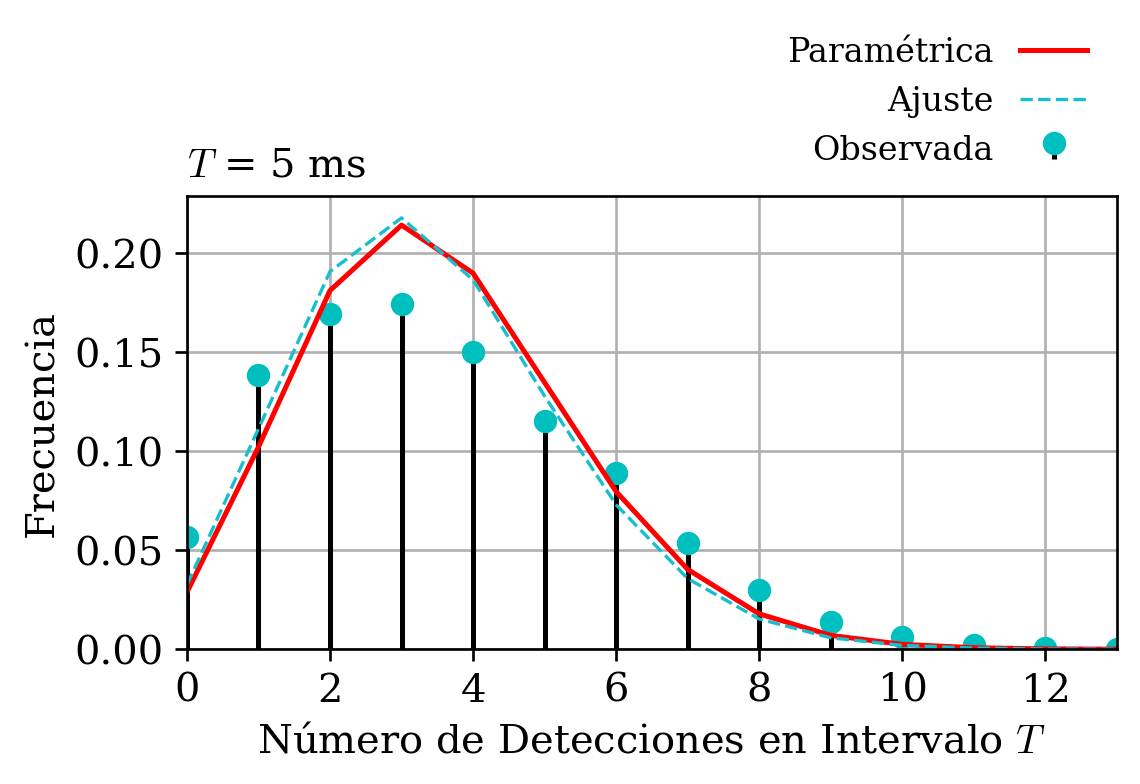

In [13]:
umbral = -30e-3  # V
dt = 200  # μs
T = 5e-3  # s
freq = 250e3  # Hz
peak_window = int(dt*freq*1e-6)
tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/"
                            + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
t, v = ut.get_peaks(tiempo, volt_vals, peak_window)  # s, V
t, v = t[:t.size//2], v[:v.size//2]  # Keep just the max extremes


counts = ut.count_in_period(t, v, T, freq, umbral, peak_window)
unique_vals, count_vals = np.unique(counts, return_counts=True, )

mean_count = counts.mean()
print(mean_count)
curve_vals = np.arange(unique_vals.min(), unique_vals.max()+1, 1)

dist_raw = poisson(mean_count).pmf(curve_vals)
dist_med = count_vals/sum(count_vals)
popt, pcov = curve_fit(poisson.pmf, unique_vals, dist_med, p0=mean_count)
dist_fit = poisson(popt[0]).pmf(curve_vals)

with plt.rc_context({
    'text.color': "k",
    'axes.labelcolor': "k",
    'xtick.color': "k",
    'ytick.color': "k",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    ax.patch.set_alpha(0)
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    # plt.hist(counts, bins=20,
    #          color=f"C{color_id}", zorder=10, edgecolor="k",
    #          alpha=0.5, label=config + " Sample")
    plt.stem(unique_vals, dist_med,
             linefmt="k", markerfmt="oc", basefmt="None",
             label="Observada")
    plt.plot(curve_vals, dist_raw, '-r', lw=1.5, label="Paramétrica")
    plt.plot(curve_vals, dist_fit, '--C9', lw=1, label="Ajuste")
    plt.legend(frameon=False, loc="lower right", bbox_to_anchor=(1, 1),
               markerfirst=False)
    plt.ylim(bottom=0)
    plt.xlabel("Número de Detecciones en Intervalo $T$")
    plt.ylabel("Frecuencia")
    # plt.yticks(np.arange(0, 0.125, 0.050), labels=[f"{i}/100" for i in range(0, 15, 5)])
    plt.title(rf"$T$ = {T*1e3:.0f} ms", loc="left")
    plt.show()

### $\tau_c >> T$: Bose-Einstein

/home/agus/mambaforge/envs/facu39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


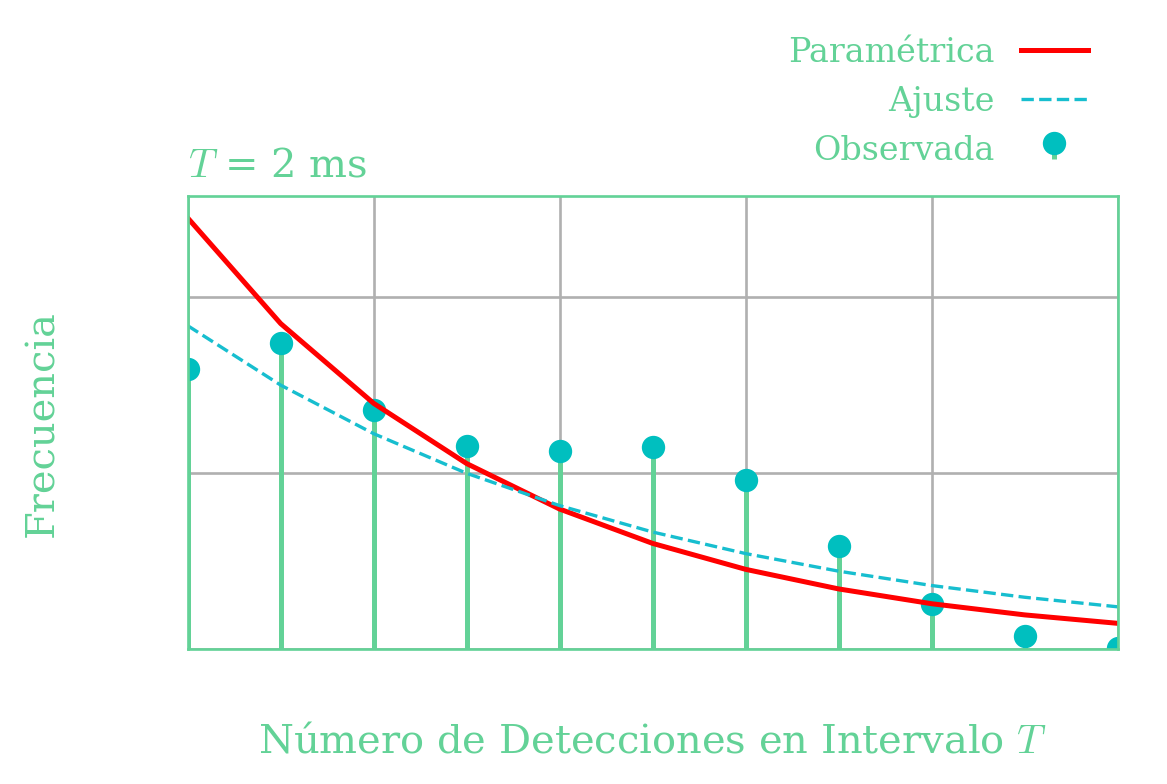

In [9]:
def bose_einstein_pmf(m, mu):
    return (mu**m)/(1 + mu)**(1+m)

def dist_sum(m, mu_p, mu_e):
    return poisson.pmf(m, mu_p) + bose_einstein_pmf(m, mu_e)


umbral = -30e-3  # V
dt = 200  # μs
T = 2e-3  # s
freq = 250e3  # Hz
peak_window = int(dt*freq*1e-6)
tiempo, volt_vals = np.load(f"DAQ_50s_{max_val*1e3:.0f}_{min_val*1e3:.0f}_rueda/"
                            + f"{modo}_f{freq*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
t, v = ut.get_peaks(tiempo, volt_vals, peak_window)  # s, V
t, v = t[:t.size//2], v[:v.size//2]  # Keep just the max extremes


counts = ut.count_in_period(t, v, T, freq, umbral, peak_window)
unique_vals, count_vals = np.unique(counts, return_counts=True, )

mean_count = counts.mean()
curve_vals = np.arange(unique_vals.min(), unique_vals.max()+1, 1)

dist_raw = bose_einstein_pmf(curve_vals, mean_count)
dist_med = count_vals/sum(count_vals)
popt, pcov = curve_fit(dist_sum,
                       unique_vals, dist_med, p0=[5, mean_count])
dist_fit = dist_sum(curve_vals, *popt)

with plt.rc_context({
    'text.color': "#63d297",
    'axes.labelcolor': "#63d297",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    ax.patch.set_alpha(0)
    for spine in ax.spines.values():
        spine.set_edgecolor('#63d297')
    # plt.hist(counts, bins=20,
    #          color=f"C{color_id}", zorder=10, edgecolor="k",
    #          alpha=0.5, label=config + " Sample")
    plt.stem(unique_vals, dist_med,
             linefmt="#63d297", markerfmt="oc", basefmt="None",
             label="Observada")
    plt.plot(curve_vals, dist_raw, '-r', lw=1.5, label="Paramétrica")
    plt.plot(curve_vals, dist_fit, '--C9', lw=1, label="Ajuste")
    plt.legend(frameon=False, loc="lower right", bbox_to_anchor=(1, 1),
               markerfirst=False)
    plt.ylim(bottom=0)
    plt.xlabel("Número de Detecciones en Intervalo $T$")
    plt.ylabel("Frecuencia")
    plt.yticks(np.arange(0, 0.25, 0.10), labels=[f"{i}/10" for i in range(0, 3, 1)])
    plt.title(rf"$T$ = {T*1e3:.0f} ms", loc="left")
    plt.show()

## Portada

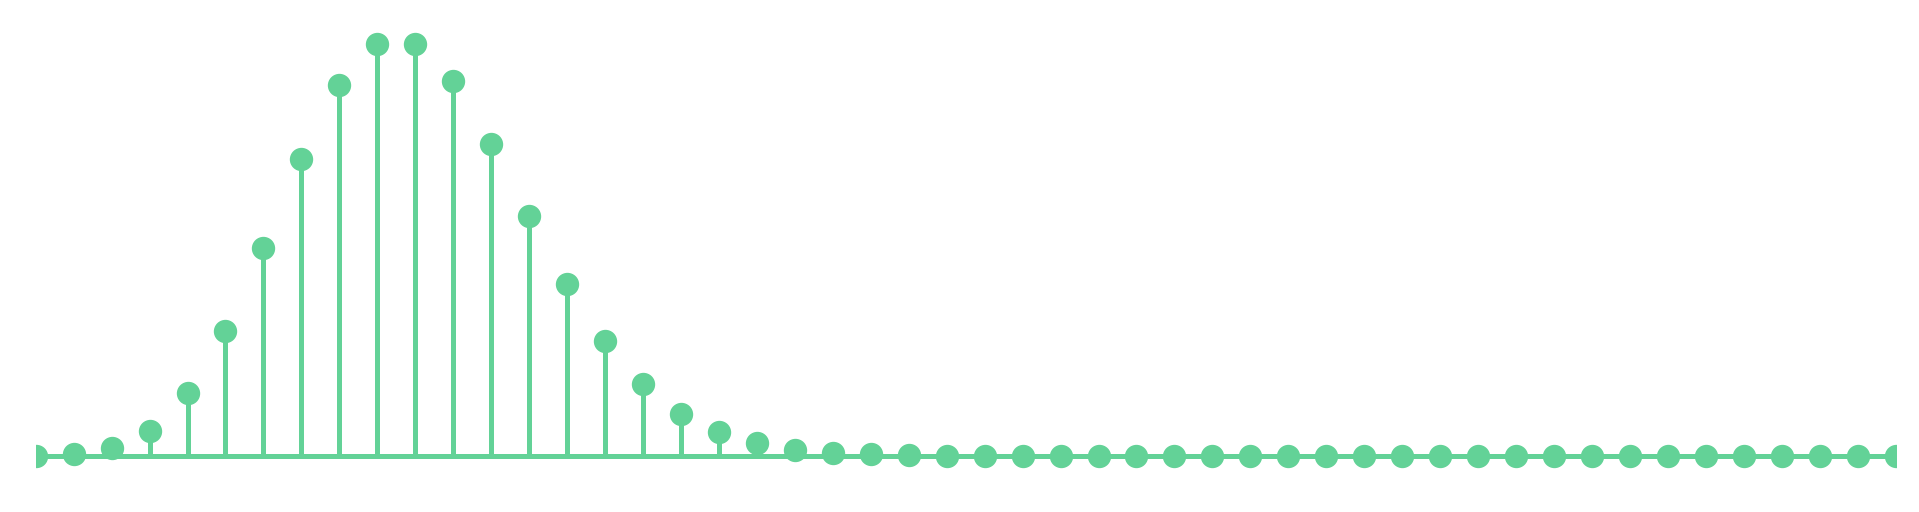

In [72]:
with plt.rc_context({
    'text.color': "#63d297",
    'axes.labelcolor': "#63d297",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
    ax.patch.set_alpha(0)
    for spine in ax.spines.values():
        spine.set_edgecolor('None')

    x = np.arange(0, 50, 1)
    y = poisson.pmf(x, 10)
    plt.stem(x, y,
             linefmt="#63d297", markerfmt="None", basefmt="#63d297",
             label="Observada")
    plt.plot(x, y, "o", c="#63d297")
    plt.yticks([])
    plt.xticks([])
    plt.show()